# Non linear relation

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import networkx as nx

import heapq

import scipy as sp
from sklearn.preprocessing import StandardScaler
from scipy.special import betainc

import numba 

from concurrent.futures import ProcessPoolExecutor, as_completed

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [6]:
test = False

In [7]:
path_cross_tt = '/home/thomas/Documents/git/medulloblastoma_cavalli_kaggle/data/dge/cross_tt_genes_wnt_vs_all.csv'
path_adj_mat_pearson_wnt = '/home/thomas/Documents/git/medulloblastoma_cavalli_kaggle/data/network/adj_mat_pearson_wnt_target_mannwhitneyu.csv'
path_adj_mat_pearson = '/home/thomas/Documents/git/medulloblastoma_cavalli_kaggle/data/network/adj_mat_pearson.csv'
path_expr_mat='/home/thomas/Documents/git/medulloblastoma_cavalli_kaggle/data/in/protein_coding/GSE85217_M_exp_763_MB_SubtypeStudy_TaylorLab_protein_coding.csv'
path_metadata = '/home/thomas/Documents/git/medulloblastoma_cavalli_kaggle/data/in/protein_coding/GSE85217_Cavalli_subgroups_information_protein_coding.csv'

In [8]:
adj_mat_pearson_wnt = pd.read_csv(path_adj_mat_pearson_wnt,index_col=0)
cross_tt=pd.read_csv(path_cross_tt,index_col=0)
expr_mat = pd.read_csv(path_expr_mat,index_col=0)
metadata = pd.read_csv(path_metadata,index_col=0)

In [9]:
expr_mat_wnt = expr_mat.loc[metadata[metadata['Subgroup']=='WNT']['Study_ID'].to_list(),:]

In [10]:
genes_corr_mat = adj_mat_pearson_wnt.columns.tolist()
genes_wnt_dge=cross_tt[cross_tt['all']==1].index.tolist()

In [11]:
expr_mat_wnt_genes = expr_mat_wnt[list(set(genes_wnt_dge + genes_corr_mat))]

In [12]:
# standardize the data 
sc = StandardScaler()
expr_mat_wnt_sc = sc.fit_transform(expr_mat_wnt_genes)

In [13]:
def trimmed_mean(expr_mat,threshold=0.05):

    t_index=int(np.floor(expr_mat.shape[0]*(threshold/2)))

    trim_expr_mat=np.zeros((expr_mat.shape[0]-(2*t_index),expr_mat.shape[1]))

    for i in range(expr_mat.shape[1]):
        trim_expr_mat[:,i]=expr_mat[:,i][t_index:-t_index]

    return trim_expr_mat

In [14]:
expr_mat_wnt_trim=trimmed_mean(expr_mat_wnt_sc)

In [15]:
import threading
import psutil
import time

class ResourceMonitor:
    def __init__(self,t_sleep=1):
        # Event to control when to stop the monitoring thread
        self._stop_event = threading.Event()
        self.monitor_thread = threading.Thread(target=self.monitor_resources, daemon=True)
        self.t_sleep=t_sleep

    def monitor_resources(self):
        while not self._stop_event.is_set():
            print(f"RAM Usage: {psutil.virtual_memory().percent}% | CPU Usage: {psutil.cpu_percent()}%")
            time.sleep(self.t_sleep)

    def start(self):
        # Start the daemon thread
        self.monitor_thread.start()

    def stop(self):
        # Signal the thread to stop and wait for it to finish
        self._stop_event.set()
        self.monitor_thread.join()  # Wait for the thread to terminate cleanly

In [16]:
def scale_xy_to_grid(x:np.ndarray,y:np.ndarray,gridsize=(200,200),extents=None):

    if extents is None:
        xmin = x.min(axis=0)
        xmax = x.max(axis=0)
        ymin = y.min(axis=0)
        ymax = y.max(axis=0)
    else : 
        xmin, xmax, ymin, ymax = map(np.ndarray, extents)

    dx = (xmax - xmin) / (gridsize[0] - 1)
    dy = (ymax - ymin) / (gridsize[1] - 1)

    xmin = xmin.reshape(1,-1)
    ymin = ymin.reshape(1,-1)

    dx = dx.reshape(1,-1)
    dy = dy.reshape(1,-1)

    # Adjust x and y to pixel coordinates inplace
    x_pix = np.floor((x - xmin) / dx)
    y_pix = np.floor((y - ymin) / dy)
    
    return x_pix, y_pix, list(dx[0,:]), list(dx[0,:])

In [17]:
def cov_vars(x,y,nocorr=True):

    x = np.asarray(x).T[:, np.newaxis, :]
    y = np.asarray(y).T
    n = x.shape[-1]



    xm = x.mean(axis=-1, keepdims=True)
    ym = y.mean(axis=-1, keepdims=True)

    cov = np.sum((x - xm) * (y - ym), axis=-1)/(n-1)

    std_x = np.std(x, ddof=1, axis=-1)
    std_y = np.std(y, ddof=1, axis=-1)

    if nocorr:
        np.fill_diagonal(cov,0)
        
    return cov, std_x**2, std_y**2

In [18]:
def chunkify_expr_mat(expr_mat,start=0,step=10):
    
    chunk_points = list(range(start,expr_mat.shape[1],step))+[expr_mat.shape[1]]
    
    for i in range(len(chunk_points)-1):
        yield chunk_points[i],chunk_points[i+1]

In [19]:
def all_chunks(expr_mat,start=0,step=5):
    
    chunks = [chunk for chunk in chunkify_expr_mat(expr_mat=expr_mat,start=start,step=step)]

    for i,j in zip(*np.triu_indices(n=len(chunks))):
        if chunks[i]==chunks[j]:
            k = 1
        else:
            k = 0
   
        yield chunks[i], chunks[j], k


In [20]:
def set_cov(cov,vars):
    cov = cov[[0,1],:][:,[0,1]]
    cov[0,0]=vars[0]
    cov[1,1]=vars[1]
    return cov

In [21]:
def get_kernel(scotts_factor,stds,inv_cov):

    kern_nx, kern_ny = np.round(scotts_factor * 2 * np.pi * stds)

    # x & y (pixel) coords of the kernel grid, with <x,y> = <0,0> in center
    xx = np.arange(kern_nx) - kern_nx / 2.0
    yy = np.arange(kern_ny) - kern_ny / 2.0
    xx, yy = np.meshgrid(xx, yy)
     
    # Then evaluate the gaussian function on the kernel grid
    kernel = np.vstack((xx.flatten(), yy.flatten()))

    kernel = np.dot(inv_cov, kernel) * kernel
    kernel = np.sum(kernel, axis=0) / 2.0
    kernel = np.exp(-kernel).reshape(np.int64(kern_ny), np.int64(kern_nx))

    return kernel

In [22]:
def batch_mi(x,y,gridsize=(200,200),epsilon=1e-10,k=1):

    x_pix, y_pix, dx, dy = scale_xy_to_grid(x,y)

    n = x.shape[0]
    weights = np.ones(n)

    # Scaling factor for bandwidth
    scotts_factor = np.power(n, -1.0 / 6) # For 2D

    batch_mi_mat = np.zeros((x.shape[-1],y.shape[-1]))

    cov_xy, vars_x, vars_y = cov_vars(x_pix,y_pix,nocorr=True)

    for i,j in zip(*np.triu_indices(x.shape[1], k=k)):

        xyi = np.vstack((x_pix[:,i],y_pix[:,j]))
        grid = sp.sparse.coo_matrix((weights, xyi), shape=(gridsize)).toarray()

        cov = set_cov(cov_xy,(vars_x[i],vars_y[j]))

        stds = std_devs = np.sqrt(np.diag(cov))
        

        # Determine the bandwidth to use for the gaussian kernel
        inv_cov = np.linalg.inv(cov * scotts_factor**2)
            
        kernel = get_kernel(scotts_factor,stds,inv_cov)
    
        grid = sp.signal.fftconvolve(grid, kernel, mode='same').T

        det = np.linalg.det(cov)
        if det < 0 :
            sqrt_det = -np.sqrt(det)
        else :
            sqrt_det = np.sqrt(det)
    
        norm_factor = n * dx[i] * dy[j] * (2 * np.pi) * scotts_factor**2 * sqrt_det

        # Normalize the result
        grid /= norm_factor

        grid+=abs(grid.min())
    
        batch_mi_mat[i,j]=shannon_mi_from_kde(grid,epsilon=1e-10, normalize=True)

    if k == 0 :
        batch_mi_mat += batch_mi_mat.T
        
    return batch_mi_mat

In [23]:
def pool_compute_mi_mat(expr_mat,step=5,epsilon=1e-10,gridsize=(200,200),t_spleep=1):

    adj_mat = np.zeros((expr_mat.shape[1],expr_mat.shape[1]))

    monitor = ResourceMonitor(t_spleep)
    monitor.start()

    results_dict={}
    with ProcessPoolExecutor(max_workers=8) as executor:
        futures = {executor.submit(batch_mi,expr_mat[:,chunk1[0]:chunk1[1]],expr_mat[:,chunk2[0]:chunk2[1]],gridsize,epsilon,k):np.array([chunk1,chunk2]) for chunk1, chunk2, k in all_chunks(expr_mat=expr_mat,step=step)}

        for future in as_completed(futures):
            chunks = futures[future]

            try:
                adj_mat[chunks[0][0]:chunks[0][1],chunks[1][0]:chunks[1][1]]=future.result()
            except Exception as e:
                print(f"Error in processing {chunks}: {e}")

    monitor.stop()
    return adj_mat

In [24]:
def fast_kde(x,y, gridsize=(200,200), density = True, extents=None, nocorrelation=True, weights=None, cov=None):

    # SETUP
    x = np.squeeze((np.asarray(x)))
    y = np.squeeze((np.asarray(y)))

    if x.size != y.size:
        raise ValueError('Input x & y arrays must be the same size!')

    n = x.size

    if weights is None:
        # Default: Weight all points equally
        weights = np.ones(n)
    else:
        weights = np.squeeze(np.asarray(weights))
        if weights.size != x.size:
            raise ValueError('Input weights must be an array of the same size'
                    ' as input x & y arrays!')

    if extents is None:
        xmin=x.min()
        xmax=x.max()
        ymin=y.min()
        ymax=y.max()
    else :
        xmin, xmax, ymin, ymax = map(float, extents)

    dx = (xmax - xmin) / (gridsize[0] - 1)
    dy = (ymax - ymin) / (gridsize[1] - 1)

    # PRELIMINARY CALCULATIONS

    # First convert x & y over to pixel coordinates
    # (Avoiding np.digitize due to excessive memory usage!)
    
    # Adjust x and y to pixel coordinates inplace
    x_pixel = np.floor((x - xmin) / dx)
    y_pixel = np.floor((y - ymin) / dy)

    # Stack the results after adjustment
    xyi = np.vstack((x_pixel, y_pixel))

    # Next, make a 2D histogram of x & y
    # Avoiding np.histogram2d due to excessive memory usage with many points
    grid = sp.sparse.coo_matrix((weights, xyi), shape=(gridsize)).toarray()

    if cov is None:
        cov = np.cov(xyi)

    if nocorrelation:
        cov[1, 0] = 0
        cov[0, 1] = 0

    # Scaling factor for bandwidth
    scotts_factor = np.power(n, -1.0 / 6) # For 2D

    # MAKE THE GAUSSIAN KERNEL

    # First, determine how big the kernel needs to be
    std_devs = np.diag(np.sqrt(cov))
    kern_nx, kern_ny = np.round(scotts_factor * 2 * np.pi * std_devs)
 
    # Determine the bandwidth to use for the gaussian kernel
    inv_cov = np.linalg.inv(cov * scotts_factor**2) 
 
    # x & y (pixel) coords of the kernel grid, with <x,y> = <0,0> in center
    xx = np.arange(kern_nx) - kern_nx / 2.0
    yy = np.arange(kern_ny) - kern_ny / 2.0
    xx, yy = np.meshgrid(xx, yy)
 
    # Then evaluate the gaussian function on the kernel grid
    kernel = np.vstack((xx.flatten(), yy.flatten()))
    kernel = np.dot(inv_cov, kernel) * kernel
    kernel = np.sum(kernel, axis=0) / 2.0
    kernel = np.exp(-kernel).reshape(np.int64(kern_ny), np.int64(kern_nx))

    # THE KERNEL DENSITY ESTIMATE

    # Convolve the gaussian kernel with the 2D histogram, producing a gaussian
    # kernel density estimate on a regular grid
    #grid = sp.signal.convolve2d(grid, kernel, mode='same', boundary='fill').T
    grid = sp.signal.fftconvolve(grid, kernel, mode='same').T
    
    # Normalization factor to divide result by so that units are in the same
    # units as scipy.stats.kde.gaussian_kde's output.  
    #norm_factor = 2 * np.pi * cov * scotts_factor**2
    #norm_factor = np.linalg.det(norm_factor)
    #norm_factor = n * dx * dy * np.sqrt(norm_factor)
    det = np.linalg.det(cov)
    if det < 0 :
        sqrt_det = -np.sqrt(det)
    else :
        sqrt_det = np.sqrt(det)
    
    norm_factor = n * dx * dy * (2 * np.pi) * scotts_factor**2 * sqrt_det

 
    # Normalize the result
    grid /= norm_factor

    grid +=abs(grid.min())

    if density:
        grid /=np.sum(grid)

    return np.flipud(grid)

In [25]:
def shannon_mi_from_kde(kde,epsilon=1e-10, norm=True, corr = True):

    p_xy = kde / np.sum(kde)
        
    if corr :
        corr_thresh = (1 / (p_xy.shape[0] * p_xy.shape[1]))
        p_xy = np.where(p_xy <= corr_thresh, 0, p_xy)
        p_xy /= np.sum(p_xy)
        mask = np.where(p_xy==0,0,1)
    else :
        mask = np.ones_like(p_xy)

    p_x = np.sum(p_xy, axis=0,keepdims=True)
    p_y = np.sum(p_xy, axis=1,keepdims=True)

    px_py = mask * (p_x * p_y)
    px_py /= np.sum(px_py)

    px_py_ones = px_py + (np.ones_like(px_py) - mask)
    p_xy_ones = p_xy + (np.ones_like(p_xy) - mask)

    mi = np.sum(p_xy * np.log2(p_xy_ones/px_py_ones))
  
    #mi = np.sum(p_xy * np.log2(p_xy / ((p_x * p_y) + epsilon)))

    h_x = -np.sum(p_x * np.log2(p_x + epsilon))
    h_y = -np.sum(p_y * np.log2(p_y + epsilon))

    if norm:
         mi /= np.sqrt(h_x * h_y)
    return mi

In [26]:
def joint_entropies(data,gridsize=(200,200),epsilon=1e-100):

    kde_2d = np.zeros((data.shape[-1],data.shape[-1],gridsize[0],gridsize[1]))
    for i in range(data.shape[1]):
        for j in range(data.shape[1]):
            kde_2d[i,j]=fast_kde(x=data[:,i],y=data[:,j], gridsize=gridsize,density=True)
    probs = (kde_2d/data.shape[0]) + epsilon
    joint_entropies = -(probs * np.log2(probs)).sum((2,3))
    return joint_entropies

In [43]:
def mutual_info_matrix(data, gridsize=(10,10), norm=True):

    n = data.shape[-1]
    j_entropies = joint_entropies(data=data,gridsize=gridsize)
    entropies = j_entropies.diagonal()
    entropies_tile = np.tile(entropies, (n, 1))
    sum_entropies = entropies_tile + entropies_tile.T
    mi_matrix = sum_entropies - j_entropies
    if norm:
        #mi_matrix = mi_matrix * 2 / sum_entropies
        mi_matrix = mi_matrix / np.sqrt(entropies_tile * entropies_tile.T)
    return mi_matrix

In [28]:
test = joint_entropies(data = expr_mat_wnt_trim[:,0:10])

In [44]:
test2 = mutual_info_matrix(data = expr_mat_wnt_trim[:,0:20])

In [45]:
np.min(test2)

0.932054423150671

In [290]:
#nmi_mat=np.zeros((expr_mat_wnt_trim.shape[1],expr_mat_wnt_trim.shape[1]))
#for i,j in zip(*np.triu_indices(expr_mat_wnt_trim.shape[1])):
#    kde ,xyi = fast_kde(x=expr_mat_wnt_trim[:,i],y=expr_mat_wnt_trim[:,j],gridsize=(200,200))
#    nmi_mat[i,j]=shannon_mi_from_kde(kde,norm=True, corr=True)

KeyboardInterrupt: 

In [294]:
def joint_entropies(data, nbins=None):
    n_variables = data.shape[-1]
    n_samples = data.shape[0]
    if nbins == None:
        nbins = int((n_samples/5)**.5)
    histograms2d = np.zeros((n_variables, n_variables, nbins, nbins))
    for i in range(n_variables):
        for j in range(n_variables):
            histograms2d[i,j] = np.histogram2d(data[:,i], data[:,j], bins=nbins)[0]
    probs = histograms2d / len(data) + 1e-100
    joint_entropies = -(probs * np.log2(probs)).sum((2,3))
    return joint_entropies

def mutual_info_matrix(df, nbins=None, normalized=True):
    data = df.to_numpy()
    n_variables = data.shape[-1]
    j_entropies = joint_entropies(data, nbins)
    entropies = j_entropies.diagonal()
    entropies_tile = np.tile(entropies, (n_variables, 1))
    sum_entropies = entropies_tile + entropies_tile.T
    mi_matrix = sum_entropies - j_entropies
    if normalized:
        mi_matrix = mi_matrix * 2 / sum_entropies    
    return pd.DataFrame(mi_matrix, index=df.columns, columns=df.columns)

In [320]:
#from scipy.stats import gaussian_kde

In [313]:
#mi = mutual_info_matrix(df = pd.DataFrame(expr_mat_wnt_trim[:,0:100]))

In [314]:
#mi = np.asarray(mi)

In [315]:
#mi

array([[1.        , 0.0337842 , 0.09680828, ..., 0.0369712 , 0.04466083,
        0.0467749 ],
       [0.0337842 , 1.        , 0.08135896, ..., 0.00755857, 0.04102615,
        0.05499529],
       [0.09680828, 0.08135896, 1.        , ..., 0.03110569, 0.04265504,
        0.02549597],
       ...,
       [0.0369712 , 0.00755857, 0.03110569, ..., 1.        , 0.02172152,
        0.22460614],
       [0.04466083, 0.04102615, 0.04265504, ..., 0.02172152, 1.        ,
        0.07894298],
       [0.0467749 , 0.05499529, 0.02549597, ..., 0.22460614, 0.07894298,
        1.        ]])

In [317]:
#np.fill_diagonal(mi,0)

In [319]:
#np.max(mi)

0.24186736943395268

In [322]:
#genes1 = expr_mat_wnt_trim[:,1]
#genes2 = expr_mat_wnt_trim[:,1]

In [323]:
#kde ,xyi=fast_kde(x=genes1,y=genes2,gridsize=(100,100))

0.027979778919112987

In [324]:
#kde /=kde.sum()
#np.where(kde<=1/4000)
#kde = np.where(kde<=1/4000,0,kde)
#kde_pxy = (np.sum(kde,axis=0, keepdims=True))*(np.sum(kde,axis=1, keepdims=True))
#kde_pxy = np.where(kde_pxy<=1/4000,0,kde_pxy)                                             
#kde /=kde.sum()
#kde_pxy /=kde_pxy.sum()

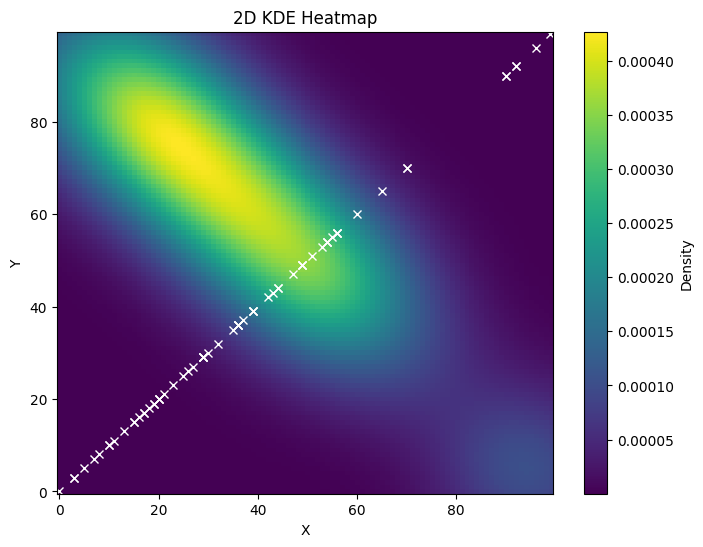

In [332]:
#kde/=np.sum(kde)
#plt.figure(figsize=(8, 6))
#plt.imshow(kde, origin='lower', cmap='viridis', aspect='auto')
#plt.imshow(kde_pxy, origin='lower', cmap='viridis', aspect='auto')
#plt.plot(xyi[0,:],xyi[1,:],'x',c="white")
#plt.colorbar(label='Density')
#plt.xlabel('X')
#plt.ylabel('Y')
#plt.title('2D KDE Heatmap')
#plt.show()

In [326]:
kde /=np.sum(kde)

In [327]:
kde +=1e-10

In [329]:
joint_entropies = -(kde * np.log2(kde)).sum()

In [330]:
kde = np.flipud(kde)

ValueError: diag requires an array of at least two dimensions

In [43]:
1/(200*200)

2.5e-05